<a href="https://www.kaggle.com/code/yacharki/5-class-classification-amazon-reviews-41-lstm?scriptVersionId=194279589" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **5 classes fine-grained Text Classification Amazon Reviews 40% LSTM**

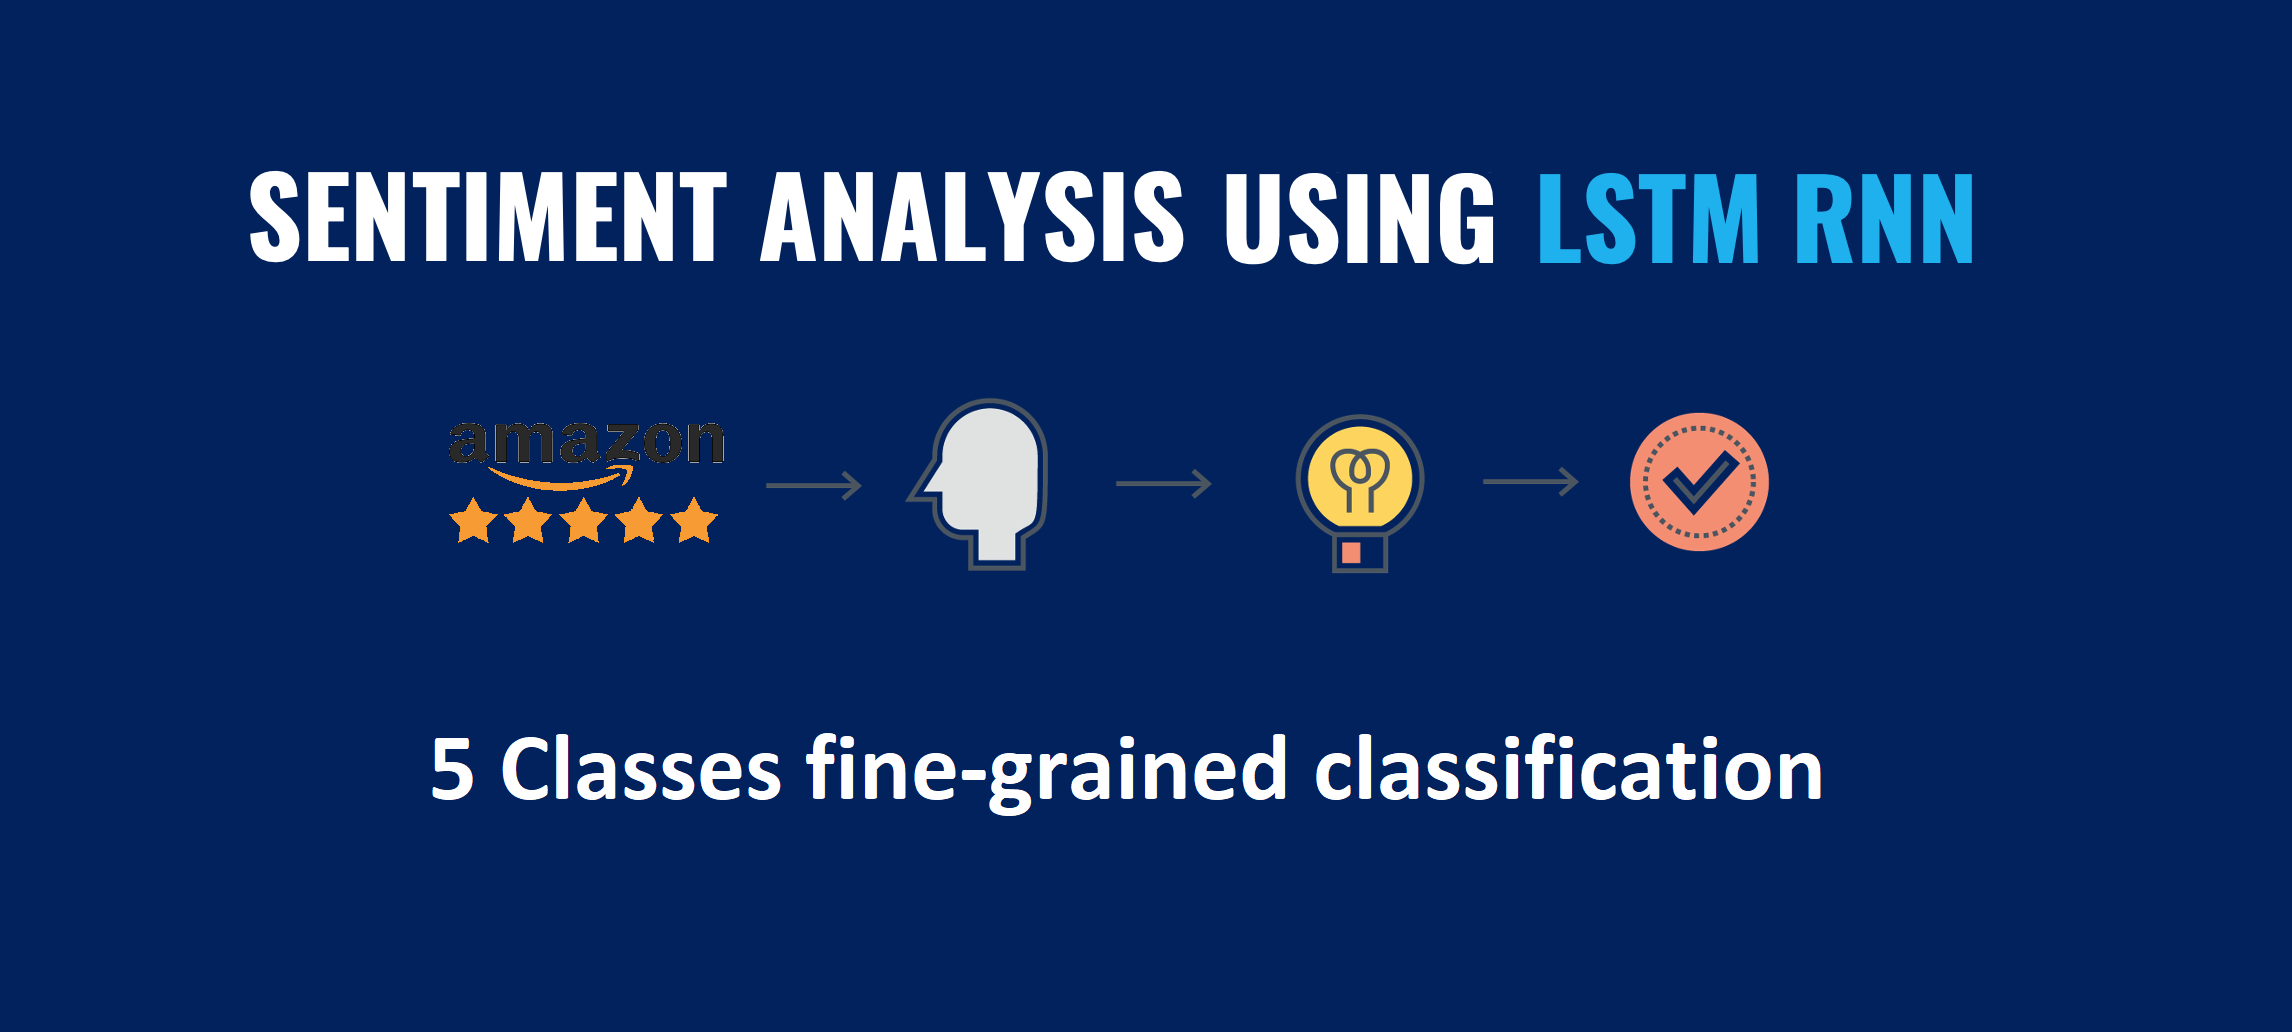

1. Download and Imports
2. Functions
3. Loading Dataset (Amazon Reviews)
4. Shuffeling and splitting the Data
5. Preprocessing and Tokenization
6. Dataset Visualization
7. Sequence Normalization and Encoding Labels
8. Model Preparation and Training
9. Visualizing and Evaluating the Results
10. Saving the model

on Github : 

on Google Colab : 

# 1. Download and Imports

In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 KB 10.7 MB/s eta 0:00:00
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
#Tensorflow and Keras and sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

#Charts
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Time
import time
import datetime

#Performance Plot
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

# 2. Functions

In [3]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [4]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [5]:
# Pre-Processing Function

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

# 3. Loading Dataset (Amazon Reviews)

In [6]:
#Reading DAtaset from csv files to Pandas dataframes

dataset_train = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
dataset_test = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')

# 4. Shuffeling and splitting the Data

In [7]:
# Shuffling Data

train = dataset_train.sample(frac=1)
test = dataset_test.sample(frac=1)

# Taking only a small peice of the dataset to avoid long training time

test = dataset_test.iloc[:100000,:]
train = dataset_train.iloc[:200000,:]


# Splitting data to train and validation sets manually, only including neccessary columns

X_train = train['review_text'].values
y_train = train['class_index'].values

X_test = test['review_text'].values
y_test = test['class_index'].values

# 5. Preprocessing and Tokenization

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

In [8]:
%%time
#Pre-processing the Data (the Reviews)

X_train = pre_process_corpus(X_train)
X_test = pre_process_corpus(X_test)

100%|██████████| 100000/100000 [00:22<00:00, 4462.32it/s]

CPU times: user 1min 6s, sys: 1.55 s, total: 1min 7s
Wall time: 1min 6s


After Pre-processing it's time for tokenazation,To perform this transformation, keras provides the ```Tokenizer```

In [9]:
# Tokenazing the Data (the Reviews)

t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [10]:
# Transforming Reviews to Sequences

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

# 6. Dataset Visualization

In [11]:
# Calculating the Vocabulary Size and the number of Reviews

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Reviews={}".format(t.document_count))

Vocabulary size=288800
Number of Reviews=200000


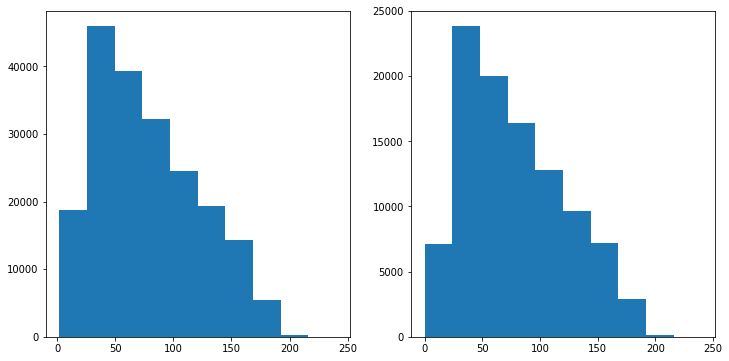

In [12]:
# Plotting the size of the sequences

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

# 7. Sequence Normalization and Encoding Labels

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [13]:
# Padding the dataset to a maximum review length in words

X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test = sequence.pad_sequences(X_test, maxlen=200)

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [14]:
# Encoding Labels

le = LabelEncoder()
num_classes=5 # Very Bad -> -2, Bad -> -1, Neutral -> 0 , Good -> 1, Very Good -> 2

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# 8. Model Preparation and Training

Before preparing the model, we need to set some variables that will be needed later# Setting Vocabulary size and Emmbedding size


In [15]:
# Hyperparameters of the model

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 200
VOCAB_SIZE = len(t.word_index)

In [16]:
# model initialization
model = Sequential()

# The Embedding Layer
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# The LSTM layer (64)
model.add(LSTM(64))

# The first DEnse layer (24,relu)
model.add(Dense(24, activation='relu'))

# The first Dense layer (5,relu)
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          86640000  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 125       
Total params: 86,735,125
Trainable params: 86,735,125
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Training the Model with GPU
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train,validation_split=(0.2), epochs=20, validation_steps=30, verbose=1)

Epoch 1/20
5000/5000 [==============================] - 158s 31ms/step - loss: 1.2833 - accuracy: 0.4273 - val_loss: 1.1750 - val_accuracy: 0.4930
Epoch 2/20
5000/5000 [==============================] - 155s 31ms/step - loss: 1.0734 - accuracy: 0.5409 - val_loss: 1.1786 - val_accuracy: 0.4961
Epoch 3/20
5000/5000 [==============================] - 155s 31ms/step - loss: 0.9589 - accuracy: 0.6046 - val_loss: 1.2165 - val_accuracy: 0.4857
Epoch 4/20
5000/5000 [==============================] - 155s 31ms/step - loss: 0.8462 - accuracy: 0.6635 - val_loss: 1.3108 - val_accuracy: 0.4724
Epoch 5/20
5000/5000 [==============================] - 154s 31ms/step - loss: 0.7380 - accuracy: 0.7134 - val_loss: 1.4146 - val_accuracy: 0.4645
Epoch 6/20
5000/5000 [==============================] - 154s 31ms/step - loss: 0.6407 - accuracy: 0.7562 - val_loss: 1.5170 - val_accuracy: 0.4554
Epoch 7/20
5000/5000 [==============================] - 155s 31ms/step - loss: 0.5561 - accuracy: 0.7909 - val_loss: 1

# 9. Visualizing and Evaluating the Results

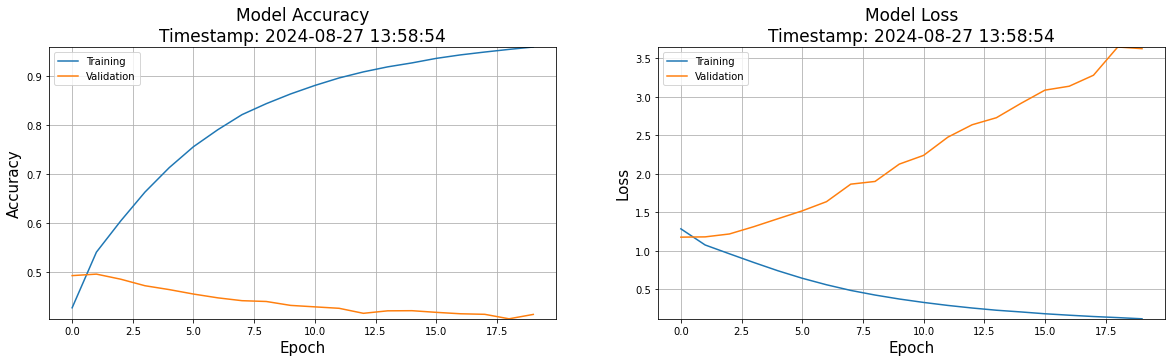

In [18]:
#Accuracy / Validation_Accuracy  and Loss / Validation_Loss Plot

plot_performance(history=history1)

In [19]:
# Final evaluation of the model

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

3125/3125 [==============================] - 14s 4ms/step - loss: 3.5687 - accuracy: 0.4141
Accuracy: 41.41%


# 10. Saving the model

In [20]:
model.save('5_Classes_40_Amazon_Reviews_LSTM.h5')

If you have any questions, feel free to contact me at yassiracharki@gmail.com or on Kaggle (: